The ppg-corrosion project is a project about the corrosion on the surface of metals. The aim is to build a model so that we can know what kind of factors can cause the errosion of the metal or speed up the errosion of the metal.  This is a classification problem since the output are categorical. 

The Key EDA visualization first tells us that the output are balanced and most of the histgrams are not 'Gaussian-like', so we need to do the preprocessing to transform the data before clustering or PCA and training and the heatmap tells us that some of the features are highly correlated. So we can do PCA to reduce the number of features that are highly correlated. The cluster visulization can tell us how many clusters the data can be divided into. 


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns 

In [2]:
### Read Data
df_cor =pd.read_csv('ppg_corrosion.csv')

## Part II) EDA

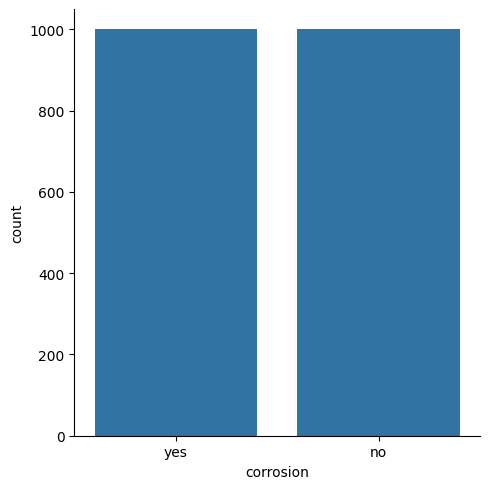

In [3]:
# bar chart for categorical variable
sns.catplot(data =df_cor, x='corrosion', kind='count')
plt.show()

In [7]:
cor_numeric_names=df_cor.select_dtypes('number').columns.to_list()

In [8]:
cor_category_names=df_cor.select_dtypes('object').columns.to_list()

In [9]:
cor_category_names

['corrosion']

In [10]:
cor_lf = df_cor.reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid']+cor_category_names,
     value_vars=cor_numeric_names)

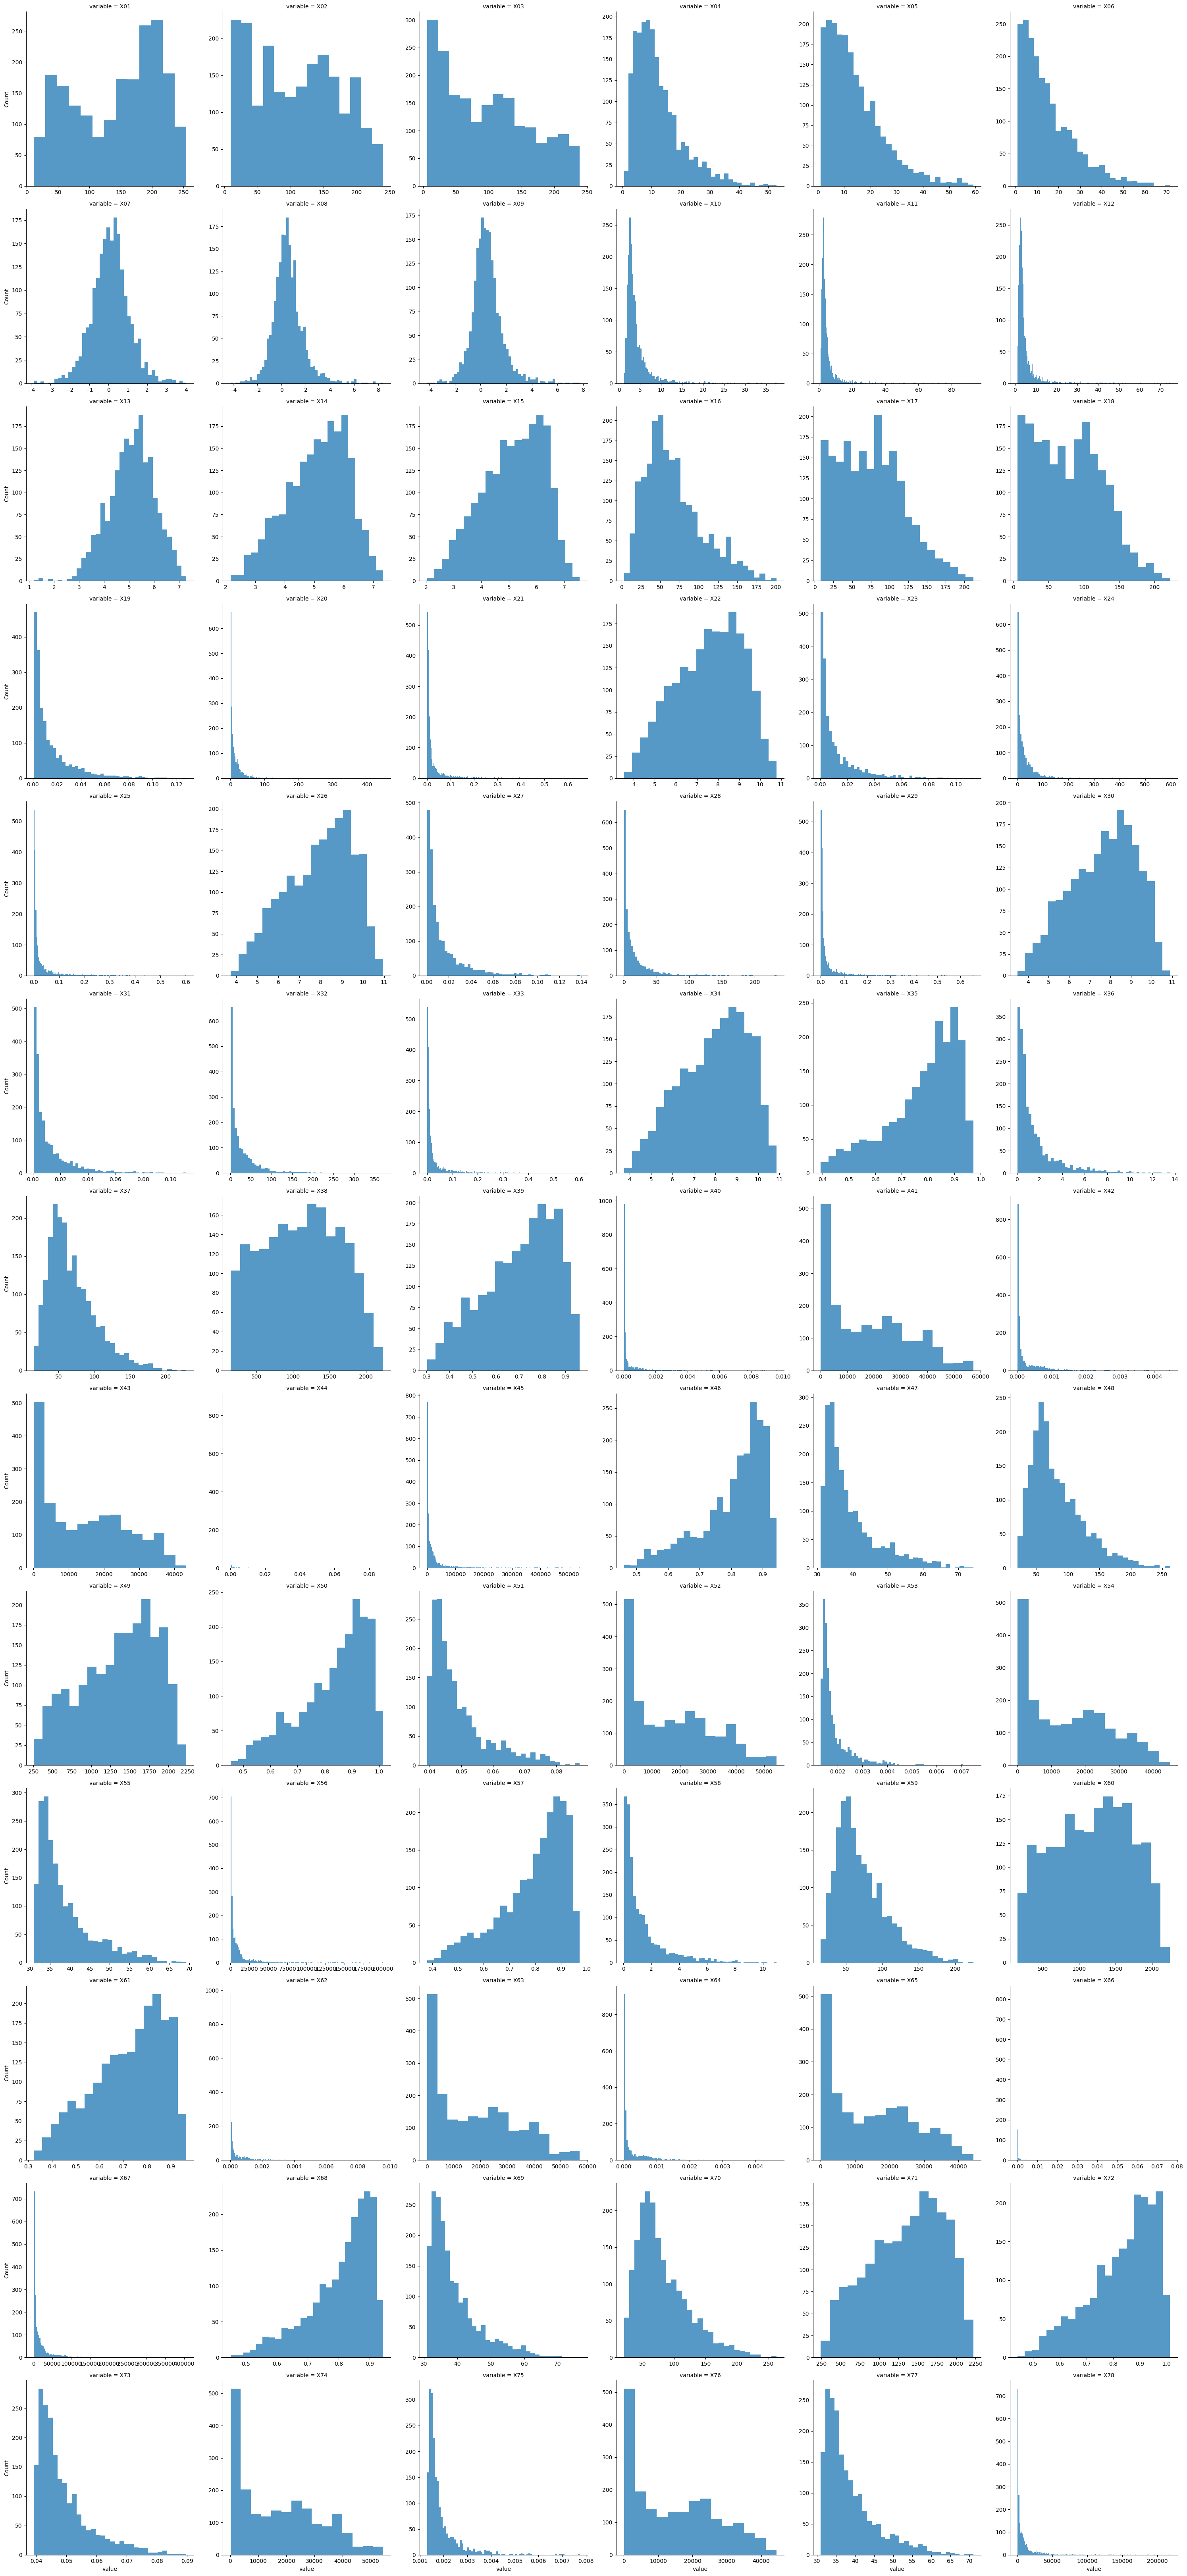

In [11]:
## Marginal distribution histogram
sns.displot(data =cor_lf, x='value', col='variable', kind='hist',
            col_wrap=6,facet_kws={'sharex':False, 'sharey':False},
            common_bins =False)
plt.show()

The histogram tells us that most of the features are not 'Gaussian-like'.

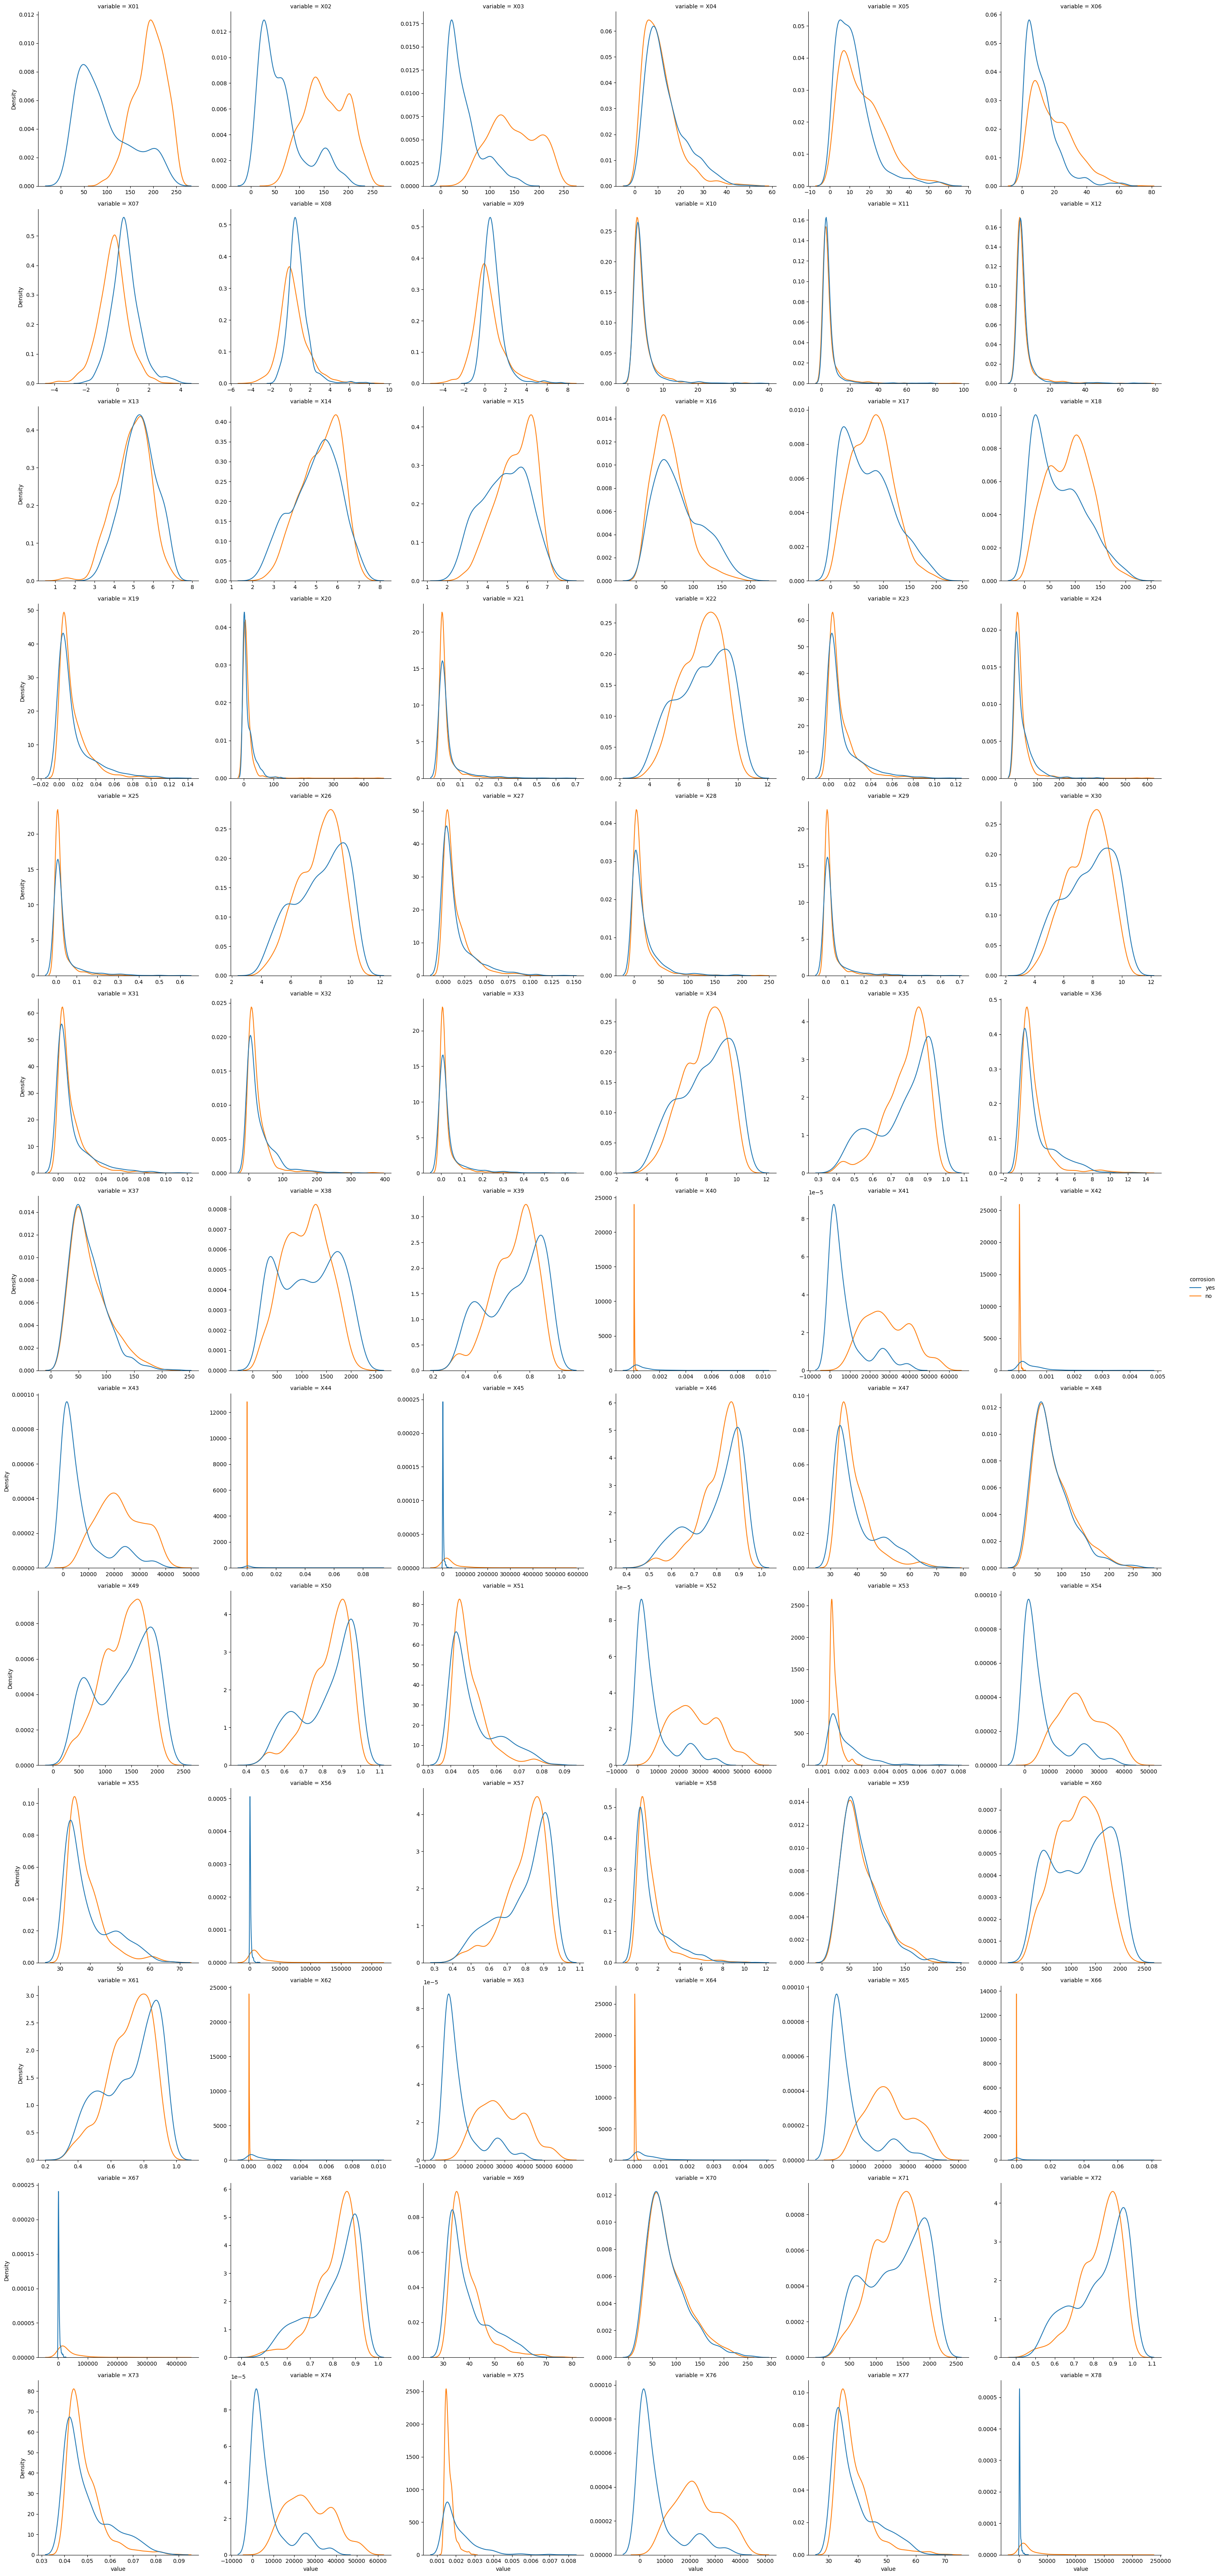

In [13]:
# kde plot
sns.displot(data =cor_lf, x='value', col ='variable', kind='kde',hue='corrosion',col_wrap=6,
            facet_kws={'sharex':False,'sharey':False},
            common_norm =False)
plt.show()

/var/folders/yf/nl1847pd63n6w_03nyrdycn80000gn/T/ipykernel_97889/3023246471.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data =df_cor.corr(),


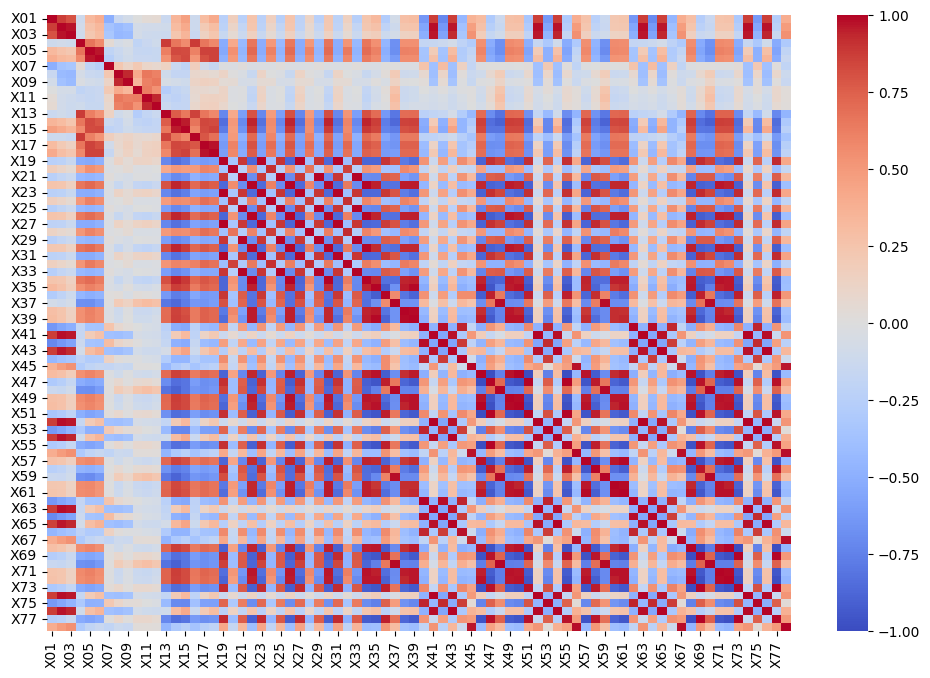

In [12]:
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(data =df_cor.corr(),
            vmin=-1,vmax=1, center=0,
            cmap='coolwarm',
            ax=ax)
plt.show()

heatmap tells us that many of the features are highly correlated.

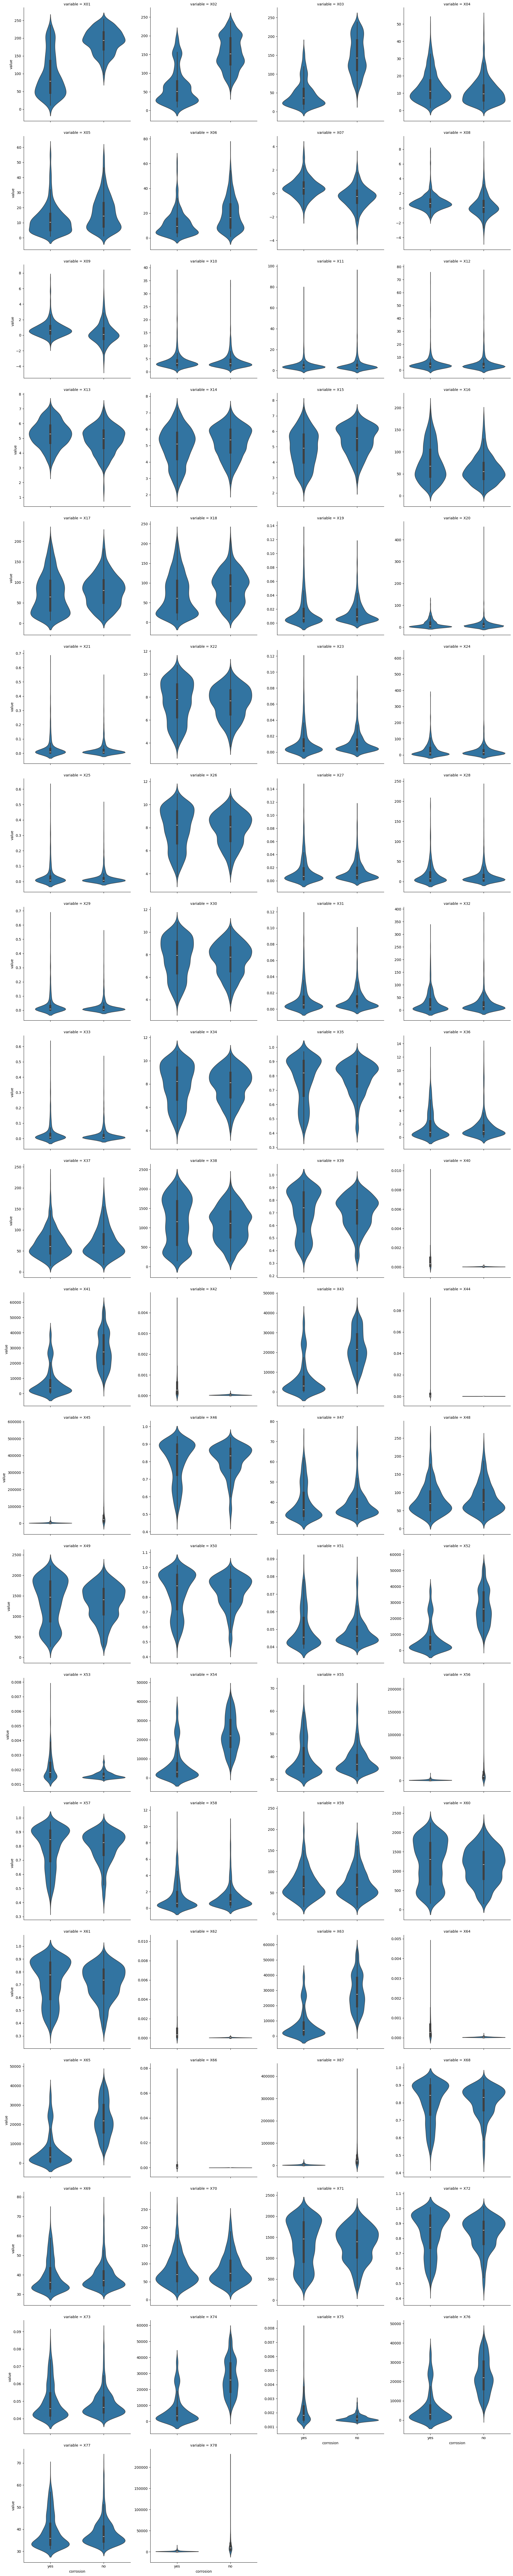

In [14]:
sns.catplot(data =cor_lf, x='corrosion', y='value', col ='variable',
            kind = 'violin',col_wrap=4, sharey=False)
plt.show()

The violin graph tells us how the data are distributed and summary statistics.

## PartIII) Clustering

In [15]:
from sklearn.preprocessing import StandardScaler

In [17]:
df_cor_num =df_cor.select_dtypes('number').copy()

In [18]:
Xdf=StandardScaler().fit_transform(df_cor_num)

In [19]:
from sklearn.cluster import KMeans

In [21]:
 #Optimal number of clusters
tots_within = []

K = range(1, 21)

for k in K:
    km = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500)
    km = km.fit( Xdf )
    
    tots_within.append( km.inertia_ )

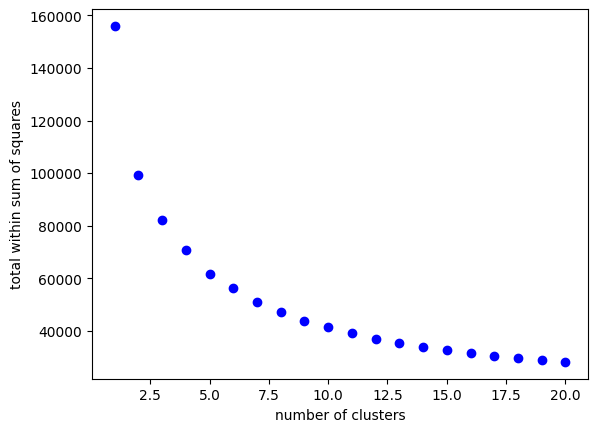

In [22]:
# Visualize the KNEE BEND plot as a line chart
fig, ax =plt.subplots()
ax.plot(K, tots_within, 'bo')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')

plt.show()

using the knee bow method, we can see that 2 or three cluesters are the optimal number of clusters

# Modeling results and visualization

In [28]:
df=pd.read_csv('ppg_corrosion.csv')

In [29]:
input_features = df.select_dtypes('number').copy().columns

In [31]:
lf = df.copy().reset_index().rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'corrosion'], value_vars=input_features, ignore_index=True)

In [32]:
small_skew_inputs = input_features[ df.select_dtypes('number').skew().between(-0.35, 0.35, inclusive='both') ]

In [34]:
#Check 0 values
lf.loc[ (lf.value == 0), :].groupby(['variable']).size()

Series([], dtype: int64)

In [35]:
# check negative values
lf.loc[ (~lf.variable.isin(small_skew_inputs)) & (lf.value < 0), :].groupby(['variable']).size()

variable
X08    627
X09    630
dtype: int64

In [36]:
lf_skew = lf.loc[ ~lf.variable.isin(small_skew_inputs), :].copy()

lf_skew = lf_skew.loc[ ~lf_skew.variable.isin(['X08', 'X09']), :].copy()

In [37]:
lf_skew['log_value'] = np.log( lf_skew.value )

In [38]:
lf_1=lf.loc[ lf.variable.isin(small_skew_inputs), :].copy()

In [39]:
lf_1['log_value'] =lf.loc[ lf.variable.isin(small_skew_inputs), :].copy().value

In [40]:
lf_2=lf.loc[ lf.variable.isin(['X08', 'X09']), :].copy()

In [41]:
lf_2['log_value'] =lf_2.value

In [43]:
df_combine=pd.concat([lf_1,lf_2,lf_skew],ignore_index=True)

In [44]:
df_wide=df_combine.pivot_table(index=['rowid','corrosion'],columns='variable', values='log_value').reset_index()

In [45]:
df_wide.drop('rowid', axis =1, inplace=True)

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
transformed_features =df_wide.select_dtypes('number').copy()

In [48]:
Xfeature_trans=StandardScaler().fit_transform(transformed_features)

In [49]:
from sklearn.decomposition import PCA

In [51]:
# execute PCA without choosing pc numbers
df_pca=PCA().fit_transform(Xfeature_trans)

In [52]:
df_pca_pc=pd.DataFrame(df_pca,
                       columns=['pc%02d' % d for d in range(1,df_pca.shape[1]+1)])

In [53]:
df_pca_pc=pd.DataFrame(df_pca,
                       columns=['pc%02d' % d for d in range(1,df_pca.shape[1]+1)])

In [57]:
import statsmodels.formula.api as smf

In [58]:
fit_05=smf.logit(formula='y~pc01+pc02+pc03+pc04+pc05+pc06+pc07+pc08+pc09+pc10+pc11+pc12+pc13+pc14+pc15+pc16+pc17', data =df_pca_pc).fit()

PatsyError: Error evaluating factor: NameError: name 'y' is not defined
    y~pc01+pc02+pc03+pc04+pc05+pc06+pc07+pc08+pc09+pc10+pc11+pc12+pc13+pc14+pc15+pc16+pc17
    ^

In [54]:
dfviz_05=pd.DataFrame([(pc12,pc14,pc15) for pc12 in np.linspace(df_pca_pc.pc12.min(),df_pca_pc.pc12.max(),num=101) 
                                  for pc14 in np.linspace(df_pca_pc.pc14.min(),df_pca_pc.pc14.max(),num=5)
                                  for pc15 in np.linspace(df_pca_pc.pc15.min(),df_pca_pc.pc15.max(),num=5) 
                                  ], columns=['pc12','pc14','pc15'])

In [55]:
dfviz_05['pc01'] =df_pca_pc.pc01.mean()
dfviz_05['pc02'] =df_pca_pc.pc02.mean()
dfviz_05['pc03']= df_pca_pc.pc03.mean()
dfviz_05['pc04'] =df_pca_pc.pc04.mean()
dfviz_05['pc05']=df_pca_pc.pc05.mean()
dfviz_05['pc06']= df_pca_pc.pc06.mean()
dfviz_05['pc07'] =df_pca_pc.pc07.mean()
dfviz_05['pc08']=df_pca_pc.pc08.mean()
dfviz_05['pc09']= df_pca_pc.pc09.mean()
dfviz_05['pc10']= df_pca_pc.pc10.mean()
dfviz_05['pc11']= df_pca_pc.pc11.mean()
dfviz_05['pc13']= df_pca_pc.pc13.mean()
dfviz_05['pc16']= df_pca_pc.pc16.mean()
dfviz_05['pc17']=df_pca_pc.pc17.mean()
dfviz_05['pc18']= df_pca_pc.pc18.mean()
dfviz_05['pc19']=df_pca_pc.pc19.mean()
dfviz_05['pc20']= df_pca_pc.pc20.mean()
dfviz_05['pc21']=df_pca_pc.pc21.mean()
dfviz_05['pc22']=df_pca_pc.pc22.mean()
dfviz_05['pc23']= df_pca_pc.pc23.mean()
dfviz_05['pc24']= df_pca_pc.pc24.mean()
dfviz_05['pc25']=  df_pca_pc.pc25.mean()
dfviz_05['pc26']=df_pca_pc.pc26.mean()
dfviz_05['pc27']=df_pca_pc.pc27.mean()
dfviz_05['pc28']= df_pca_pc.pc28.mean()
dfviz_05['pc29']= df_pca_pc.pc29.mean()
dfviz_05['pc30']= df_pca_pc.pc30.mean()
dfviz_05['pc31']= df_pca_pc.pc31.mean()
dfviz_05['pc32']= df_pca_pc.pc32.mean()
dfviz_05['pc33']= df_pca_pc.pc33.mean()
dfviz_05['pc34']= df_pca_pc.pc34.mean()
dfviz_05['pc35']=df_pca_pc.pc35.mean()
dfviz_05['pc36']= df_pca_pc.pc36.mean()
dfviz_05['pc37']=df_pca_pc.pc37.mean()
dfviz_05['pc38']= df_pca_pc.pc38.mean()
dfviz_05['pc39']=df_pca_pc.pc39.mean()
dfviz_05['pc40']= df_pca_pc.pc40.mean()
dfviz_05['pc41']= df_pca_pc.pc41.mean()
dfviz_05['pc42']= df_pca_pc.pc42.mean()
dfviz_05['pc43']= df_pca_pc.pc43.mean()
dfviz_05['pc44']= df_pca_pc.pc44.mean()
dfviz_05['pc45']= df_pca_pc.pc45.mean()
dfviz_05['pc46']= df_pca_pc.pc46.mean()
dfviz_05['pc47']=df_pca_pc.pc47.mean()
dfviz_05['pc48']= df_pca_pc.pc48.mean()
dfviz_05['pc49']= df_pca_pc.pc49.mean()
dfviz_05['pc50']= df_pca_pc.pc50.mean()
dfviz_05['pc51']= df_pca_pc.pc51.mean()
dfviz_05['pc52']= df_pca_pc.pc52.mean()
dfviz_05['pc53']=df_pca_pc.pc53.mean()
dfviz_05['pc54']= df_pca_pc.pc54.mean()
dfviz_05['pc55']= df_pca_pc.pc55.mean()
dfviz_05['pc56']= df_pca_pc.pc56.mean()
dfviz_05['pc57']= df_pca_pc.pc57.mean()
dfviz_05['pc58']= df_pca_pc.pc58.mean()
dfviz_05['pc59']= df_pca_pc.pc59.mean()
dfviz_05['pc60']= df_pca_pc.pc60.mean()
dfviz_05['pc61']= df_pca_pc.pc61.mean()
dfviz_05['pc62']= df_pca_pc.pc62.mean()
dfviz_05['pc63']= df_pca_pc.pc63.mean()
dfviz_05['pc64']= df_pca_pc.pc64.mean()
dfviz_05['pc65']= df_pca_pc.pc65.mean()
dfviz_05['pc66']= df_pca_pc.pc66.mean()
dfviz_05['pc67']=  df_pca_pc.pc67.mean()
dfviz_05['pc68']=df_pca_pc.pc68.mean()
dfviz_05['pc69']= df_pca_pc.pc69.mean()
dfviz_05['pc70']= df_pca_pc.pc70.mean()
dfviz_05['pc71']=  df_pca_pc.pc71.mean()
dfviz_05['pc72']= df_pca_pc.pc72.mean()
dfviz_05['pc73']=  df_pca_pc.pc73.mean()
dfviz_05['pc74']=  df_pca_pc.pc74.mean()
dfviz_05['pc75']= df_pca_pc.pc75.mean()
dfviz_05['pc76']= df_pca_pc.pc76.mean()
dfviz_05['pc77']= df_pca_pc.pc77.mean()
dfviz_05['pc78']= df_pca_pc.pc78.mean()